In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lshash import LSHash
from math import radians, cos, sin, asin, sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def input():

    # file input
    data = pd.read_csv('data_2g.csv', index_col=None)
    gongcan = pd.read_csv('2g_gongcan.csv', index_col=None)

    # data merge
    for i in range(1, 8):
        gongcan_temp = gongcan.rename(columns={'RNCID': 'RNCID_' + str(i),'CellID': 'CellID_' + str(i),'Latitude': 'Latitude_' + str(i),'Longitude': 'Longitude_' + str(i)})
        data = pd.merge(data, gongcan_temp, how='left', on=['RNCID_' + str(i), 'CellID_' + str(i)])
        
    # make groups
    groups = []
    for index, row in gongcan.rename(columns={'RNCID': 'RNCID_1','CellID': 'CellID_1'}).iterrows():
        group = pd.merge(data, pd.DataFrame().append(row).drop(['Latitude','Longitude'], axis=1), on=['RNCID_1','CellID_1'])
        if group.size > 1:
            groups.append(group)

    return groups


def classify(data):

    # transfer from absolute to relative
    data['Longitude'] = data['Longitude'] - data['Longitude_1']
    data['Latitude'] = data['Latitude'] - data['Latitude_1']

    return data


def reverse(result, data_set):

    pos_set = pd.DataFrame()
    pos_set['Longitude_1'] = data_set['Longitude_1']
    pos_set['Latitude_1'] = data_set['Latitude_1']
    pos_set = pos_set.reset_index() 
    result = pd.concat([result, pos_set], axis=1, ignore_index=True)
    result.columns = ['lon_pred','lat_pred','no','Longitude_1','Latitude_1']

    result['Longitude_pred'] = result['lon_pred'] / 100000000.0 + result['Longitude_1']
    result['Latitude_pred'] = result['lat_pred'] / 100000000.0 + result['Latitude_1']

    return result.drop(['lat_pred','lon_pred','Longitude_1','Latitude_1','no'], axis=1)


def evaluate(test_set, result_set):

    # calculate the abs range
    compare_set = pd.concat([test_set.reset_index(drop=True), result_set.reset_index(drop=True)], axis=1, ignore_index=True)
    compare_set['lon_dev'] = abs(compare_set[0] - compare_set[2])
    compare_set['lat_dev'] = abs(compare_set[1] - compare_set[3])
    
    # calculate the deviation
    compare_set['error'] = compare_set['lon_dev'] + compare_set['lat_dev']
    compare_set = compare_set.sort_values(['error'])

    # get point
    deviation = [0]
    for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        deviation.append(haversine(compare_set.iloc[int(i*compare_set.shape[0]), ]['error'],0,0,0)*1000)

    return deviation


def createInitSet(data):

    # create training set
    training_set = data.sample(frac=0.8 if data.shape[0] > 2 else 0.5).sort_index()

    training_labels = pd.DataFrame()
    training_labels['Longitude'] = training_set['Longitude'] * 100000000
    training_labels['Latitude'] = training_set['Latitude'] * 100000000
    training_labels['Longitude'] = training_labels['Longitude'].apply(int)
    training_labels['Latitude'] = training_labels['Latitude'].apply(int)

    training_features = training_set.drop(['IMSI','MRTime','Longitude','Latitude','Num_connected','RNCID_1','CellID_1','RNCID_2','CellID_2','RNCID_3','CellID_3','RNCID_4','CellID_4','RNCID_5','CellID_5','RNCID_6','CellID_6','RNCID_7','CellID_7'], axis=1).fillna(0)

    # create test set
    test_set = data.append(training_set).drop_duplicates(keep=False).sort_index()

    test_labels = pd.DataFrame()
    test_labels['Longitude'] = test_set['Longitude'] * 100000000
    test_labels['Latitude'] = test_set['Latitude'] * 100000000
    test_labels['Longitude'] = test_labels['Longitude'].apply(int)
    test_labels['Latitude'] = test_labels['Latitude'].apply(int)

    test_features = test_set.drop(['IMSI','MRTime','Longitude','Latitude','Num_connected','RNCID_1','CellID_1','RNCID_2','CellID_2','RNCID_3','CellID_3','RNCID_4','CellID_4','RNCID_5','CellID_5','RNCID_6','CellID_6','RNCID_7','CellID_7'], axis=1).fillna(0)

    test_pos = pd.DataFrame()
    test_pos['Longitude'] = test_set['Longitude'] + test_set['Longitude_1']
    test_pos['Latitude'] = test_set['Latitude'] + test_set['Latitude_1']

    return training_features, test_features, training_labels, test_labels, test_pos


RandomForestClassifier CDF 1 : 


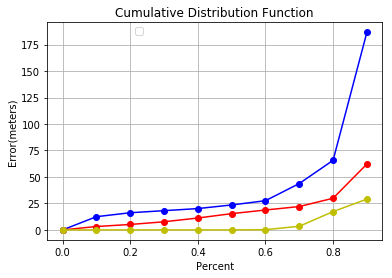

RandomForestClassifier CDF 2 : 


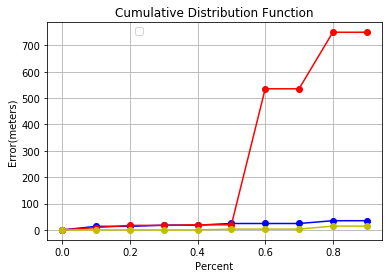

RandomForestClassifier CDF 3 : 


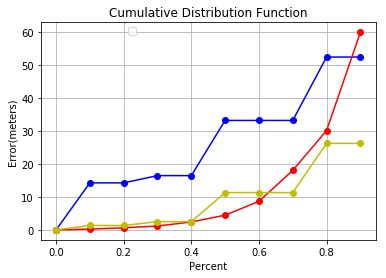

RandomForestClassifier CDF 4 : 


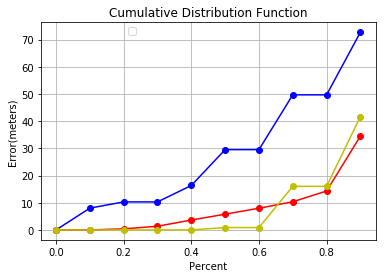

RandomForestClassifier CDF 5 : 


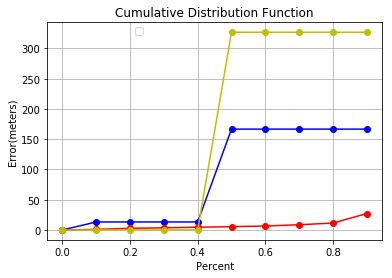

RandomForestClassifier CDF 6 : 


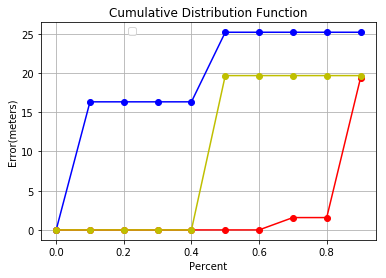

RandomForestClassifier CDF 7 : 


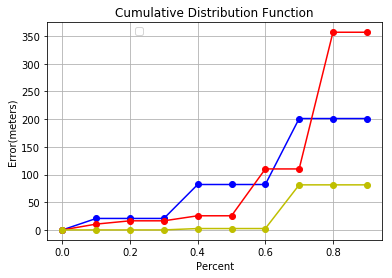

RandomForestClassifier CDF 8 : 


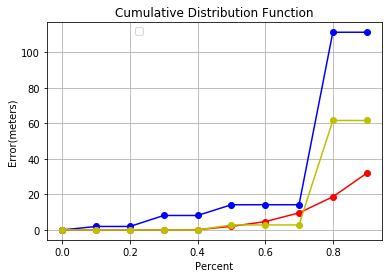

In [2]:
if __name__ == '__main__':

    # input
    data_set = input()
    mid_error = []
    for group in data_set:

        # for each group
        error_set = []
        group_set = classify(group)

        for i in range(0, 10):

            # init data set
            training_set, test_set, training_labels, test_labels, test_pos = createInitSet(group_set)

            # RandomForestClassifier
            # train
            clf = RandomForestClassifier().fit(training_set, training_labels)

            # test
            pred = clf.predict(test_set)

            # transform into real pos
            result = reverse(pd.DataFrame(data=pred, columns=['lon_pred', 'lat_pred']), test_set)

            # evaluate
            error_set.append(evaluate(test_pos, result))

        # calculate the deviation
        avr_error = []
        error_set = pd.DataFrame(data=error_set)
        for i in range(0, 10):
            avr_error.append(error_set[i].mean())

        # error[5] == 0 only if the data sample is not enough to build a clf
        if avr_error[5] != 0.0:
            mid_error.append(avr_error[5])

    # get topk-
    K = int(0.2*len(mid_error))
    topkm_mid_err = np.sort(mid_error)[-K:]
    topkp_mid_err = np.sort(mid_error)[:K]

    # regroup
    topkms = []
    topkps = []
    for i in range(0, len(mid_error)):
        if mid_error[i] in topkm_mid_err:
            # topk-
            topkms.append(data_set[i])
        elif mid_error[i] in topkp_mid_err:
            # topk+
            topkps.append(data_set[i])
    
    # retrain
    for k in range(0, K):

        # merge
        group = topkms[k]
        new_group = pd.concat([topkms[k], topkps[k]])

        # for each group
        error_set = []
        new_error_set = []
        new_error_set_old = []

        group_set = classify(group)
        new_group_set = classify(new_group)

        # use data to retrain
        for i in range(0, 10):
            # init data set
            training_set, test_set, training_labels, test_labels, test_pos = createInitSet(group_set)
            new_training_set, new_test_set, new_training_labels, new_test_labels, new_test_pos = createInitSet(new_group_set)

            # RandomForestClassifier
            # train
            clf = RandomForestClassifier().fit(training_set, training_labels)
            new_clf = RandomForestClassifier().fit(new_training_set, new_training_labels)

            # test
            pred = clf.predict(test_set)
            new_pred = new_clf.predict(new_test_set)
            new_pred_old = new_clf.predict(test_set)

            # transform into real pos
            result = reverse(pd.DataFrame(data=pred, columns=['lon_pred', 'lat_pred']), test_set)
            new_result = reverse(pd.DataFrame(data=new_pred, columns=['lon_pred', 'lat_pred']), new_test_set)
            new_result_old = reverse(pd.DataFrame(data=new_pred_old, columns=['lon_pred', 'lat_pred']), test_set)

            # evaluate
            error_set.append(evaluate(test_pos, result))
            new_error_set.append(evaluate(new_test_pos, new_result))
            new_error_set_old.append(evaluate(test_pos, new_result_old))

        # calculate the deviation
        avr_error = []
        error_set = pd.DataFrame(data=error_set)
        for i in range(0, 10):
            avr_error.append(error_set[i].mean())

        new_avr_error = []
        new_error_set = pd.DataFrame(data=new_error_set)
        for i in range(0, 10):
            new_avr_error.append(new_error_set[i].mean())

        new_avr_error_old = []
        new_error_set_old = pd.DataFrame(data=new_error_set_old)
        for i in range(0, 10):
            new_avr_error_old.append(new_error_set_old[i].mean())

        # draw the figure
        print 'RandomForestClassifier CDF', k+1, ': ' 
        group_labels = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        plt.title('Cumulative Distribution Function')  
        plt.xlabel('Percent')  
        plt.ylabel('Error(meters)')
        plt.plot(group_labels, avr_error,'bo-')
        plt.plot(group_labels, new_avr_error,'ro-')
        plt.plot(group_labels, new_avr_error_old,'yo-')
        plt.legend(bbox_to_anchor=[0.3, 1])  
        plt.grid()  
        plt.show()